# FastFashOff - Détection de logos de fast fashion

Application de recherche d'image par contenu pour détecter les logos de marques de fast fashion et sensibiliser aux impacts sociaux et environnementaux.

**Projet réalisé dans le cadre de l'UE 35LIAC04 - Informatique graphique et vision**  
Université Lyon 2 - L3 Informatique

## 1. Imports et configuration

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

# Imports des modules FastFashOff
from config import LOGOS, IMAGES, LOGO_DIR, IMAGE_DIR, MIN_MATCHES, SEUIL_DISTANCE
from data_marques import MARQUES_INFO, LOGO_TO_MARQUE
from image_processing import load_image, filter_image, resize_image
from logo_detection import (
    extraire_features_orb,
    matcher_logos,
    filtrer_bons_matches,
    valider_detection,
    dessiner_matches
)
from display import afficher_info_boycott, afficher_image_opencv, afficher_resume
from utils import (
    valider_structure_projet,
    afficher_statistiques_detection,
)

print("Modules chargés")
print(f"Configuration : MIN_MATCHES={MIN_MATCHES}, SEUIL_DISTANCE={SEUIL_DISTANCE}")


Modules chargés
Configuration : MIN_MATCHES=10, SEUIL_DISTANCE=50


## 2. Validation de la structure du projet


In [2]:
valide, message = valider_structure_projet()
print(f"{message}")

if valide:
    print(f"\nLogos disponibles : {len(LOGOS)}")
    for logo in LOGOS:
        print(f"   - {logo}")
    
    print(f"\nImages disponibles : {len(IMAGES)}")
    for img in IMAGES:
        print(f"   - {img}")

Structure du projet valide

Logos disponibles : 7
   - Bershka-logo.png
   - primark-logo.png
   - zara_logo.png
   - hm-logo.png
   - Shein-logo.png
   - uniqlo-logo.png
   - Pull_Bear-logo.png

Images disponibles : 5
   - BERSHKA.jpg
   - PRIMARK.jpg
   - ZARA.jpeg
   - H&M.jpg
   - SHEIN.jpeg


## 3. Visualisation des données


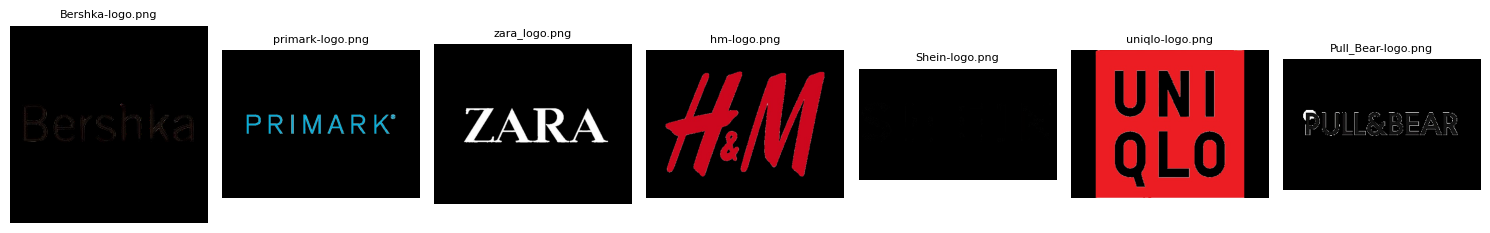

In [3]:
def afficher_logos_notebook():
    #Affiche tous les logos dans le notebook avec matplotlib
    fig, axes = plt.subplots(1, len(LOGOS), figsize=(15, 3))
    
    for i, logo_name in enumerate(LOGOS):
        logo_path = LOGO_DIR / logo_name
        img = load_image(logo_path, grayscale=False)
        
        if img is not None:
            # OpenCV charge en BGR, convertir en RGB pour matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(logo_name, fontsize=8)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

afficher_logos_notebook()

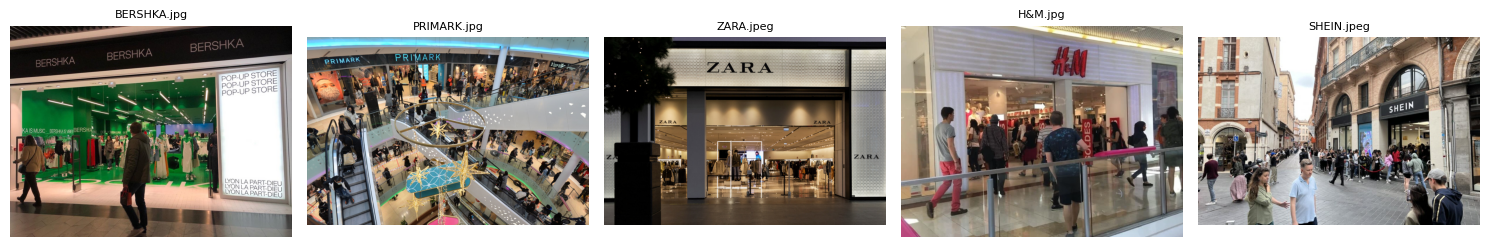

In [4]:
def afficher_images_notebook():
    #Affiche toutes les images du dataset dans le notebook.
    fig, axes = plt.subplots(1, len(IMAGES), figsize=(15, 3))
    
    for i, img_name in enumerate(IMAGES):
        img_path = IMAGE_DIR / img_name
        img = load_image(img_path, grayscale=False)
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(img_name, fontsize=8)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

afficher_images_notebook()


## 4. Test du filtre sur une image

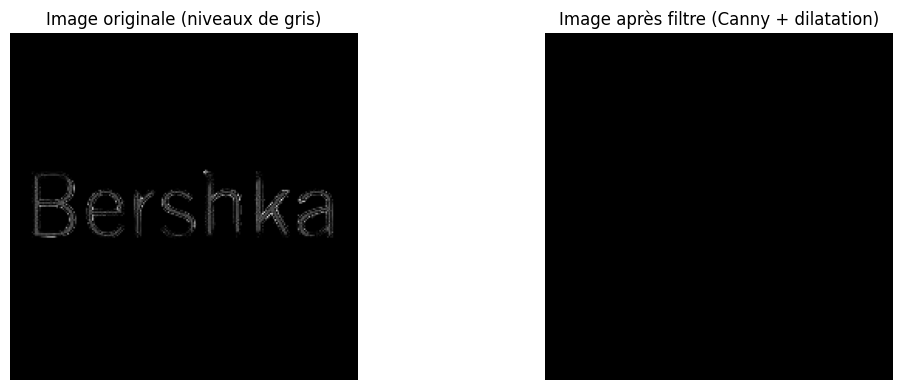

In [5]:
# Charger une image de test
test_img_path = LOGO_DIR / LOGOS[0]
img_original = load_image(test_img_path, grayscale=True)
img_filtree = filter_image(img_original)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Image originale (niveaux de gris)')
axes[0].axis('off')

axes[1].imshow(img_filtree, cmap='gray')
axes[1].set_title('Image après filtre (Canny + dilatation)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 5. Test de détection ORB sur une paire logo/image

In [6]:
def tester_detection_simple(index=0):
    """Teste la détection sur une paire logo/image spécifique."""
    logo_path = LOGO_DIR / LOGOS[index]
    img_path = IMAGE_DIR / IMAGES[index]
    
    print(f"Test : {LOGOS[index]} vs {IMAGES[index]}\n")
    
    # Chargement
    imgLogo = load_image(logo_path, grayscale=True)
    img = load_image(img_path, grayscale=True)
    
    if imgLogo is None or img is None:
        print("❌ Erreur de chargement")
        return
    
    # Filtrage
    imgLogo_filtered = filter_image(imgLogo)
    img_filtered = filter_image(img)
    
    # Extraction ORB
    kp0, des0 = extraire_features_orb(imgLogo_filtered)
    kp1, des1 = extraire_features_orb(img_filtered)
    
    print(f"Keypoints logo : {len(kp0)}")
    print(f"Keypoints image : {len(kp1)}")
    
    if des0 is None or des1 is None:
        print("❌ Pas de descripteurs")
        return
    
    # Matching
    matches = matcher_logos(des0, des1)
    good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
    
    print(f"\nMatches totaux : {len(matches)}")
    print(f"Bons matches (dist<{SEUIL_DISTANCE}) : {len(good_matches)}")
    
    if matches:
        print(f"Distance min : {matches[0].distance:.1f}")
        print(f"Distance max : {matches[-1].distance:.1f}")
    
    # Validation
    valide = valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE)
    print(f"\n{'✓ Détection VALIDE' if valide else '✗ Détection INVALIDE'}")
    
    # Affichage visuel dans le notebook
    img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 5))
    plt.imshow(img_matches_rgb)
    plt.title(f"Matching : {LOGOS[index]} vs {IMAGES[index]} ({len(good_matches)} bons matches)")
    plt.axis('off')
    plt.show()

# Tester sur la première paire (index 0 = Bershka)
tester_detection_simple(0)

Test : Bershka-logo.png vs BERSHKA.jpg

Keypoints logo : 0
Keypoints image : 1000
❌ Pas de descripteurs


Test : primark-logo.png vs PRIMARK.jpg

Keypoints logo : 885
Keypoints image : 1000

Matches totaux : 16
Bons matches (dist<50) : 15
Distance min : 21.0
Distance max : 65.0

✓ Détection VALIDE


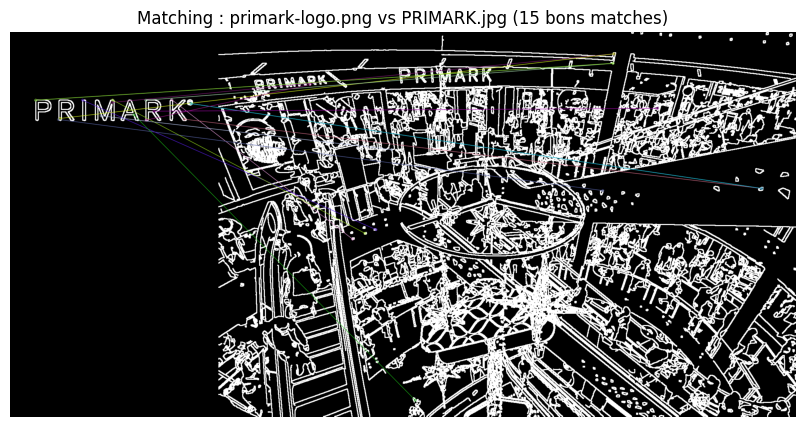

Test : zara_logo.png vs ZARA.jpeg

Keypoints logo : 839
Keypoints image : 1000

Matches totaux : 30
Bons matches (dist<50) : 27
Distance min : 9.0
Distance max : 58.0

✓ Détection VALIDE


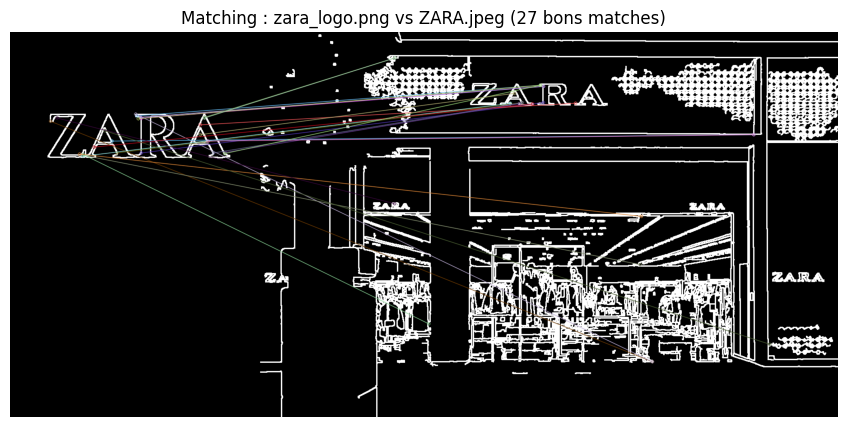

Test : hm-logo.png vs H&M.jpg

Keypoints logo : 1018
Keypoints image : 1000

Matches totaux : 90
Bons matches (dist<50) : 85
Distance min : 15.0
Distance max : 53.0

✓ Détection VALIDE


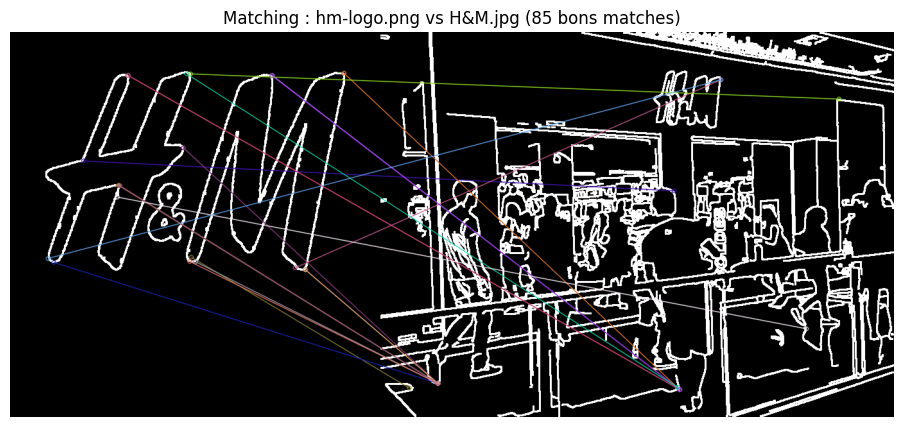

Test : Shein-logo.png vs SHEIN.jpeg

Keypoints logo : 0
Keypoints image : 1000
❌ Pas de descripteurs


IndexError: list index out of range

In [7]:
# Tester toutes les autres paires
for i in range(1, len(LOGOS)):
    tester_detection_simple(i)

## 6. Analyse complète du dataset


                 🔍 FASTFASHOFF - Analyse en cours...                  

⚠️  Pas de descripteurs pour : Bershka-logo.png ou BERSHKA.jpg
✓ Logo détecté: primark-logo.png
  → Bons matches: 15
  → Distance minimale: 21.0



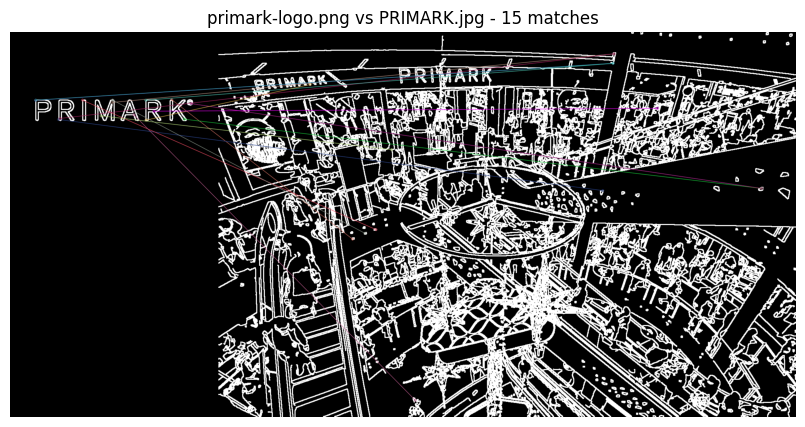


🚨 MARQUE DÉTECTÉE: Primark

📌 Contexte:
   Impliqué dans l'effondrement du Rana Plaza (Bangladesh, 2013) qui a tué plus de 1100 personnes.

❌ Raisons de boycotter:
   1. Salaires très bas et horaires excessifs pour les ouvriers
   2. Absence de transparence sur la chaîne d'approvisionnement
   3. Modèle économique basé sur l'ultra fast-fashion
   4. Utilisation massive de matières polluantes (polyester)

✅ Alternatives recommandées:
   Friperies, location de vêtements, marques responsables

✓ Logo détecté: zara_logo.png
  → Bons matches: 27
  → Distance minimale: 9.0



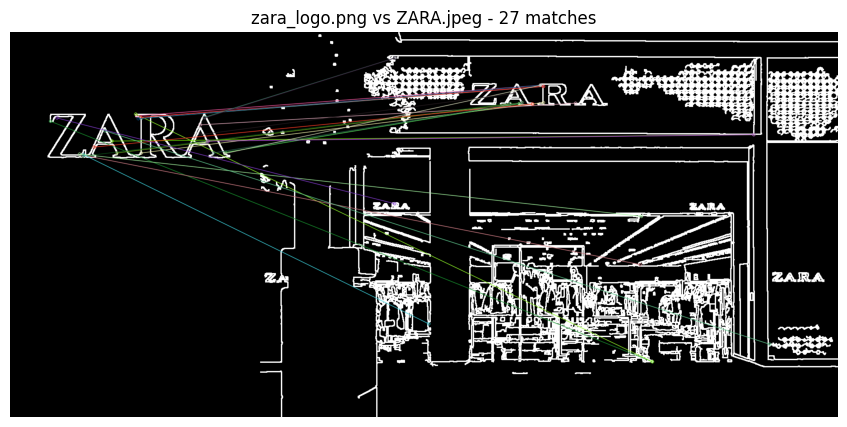


🚨 MARQUE DÉTECTÉE: Zara (groupe Inditex)

📌 Contexte:
   Leader mondial de la fast fashion. Inditex est régulièrement pointé du doigt pour ses pratiques sociales et environnementales.

❌ Raisons de boycotter:
   1. Rythme de production effréné (nouvelles collections toutes les 2 semaines)
   2. Exploitation des travailleurs dans les pays en développement
   3. Gaspillage textile massif (invendus détruits)
   4. Empreinte carbone élevée due à la logistique mondiale

✅ Alternatives recommandées:
   Mode durable, upcycling, marques locales et transparentes

✓ Logo détecté: hm-logo.png
  → Bons matches: 85
  → Distance minimale: 15.0



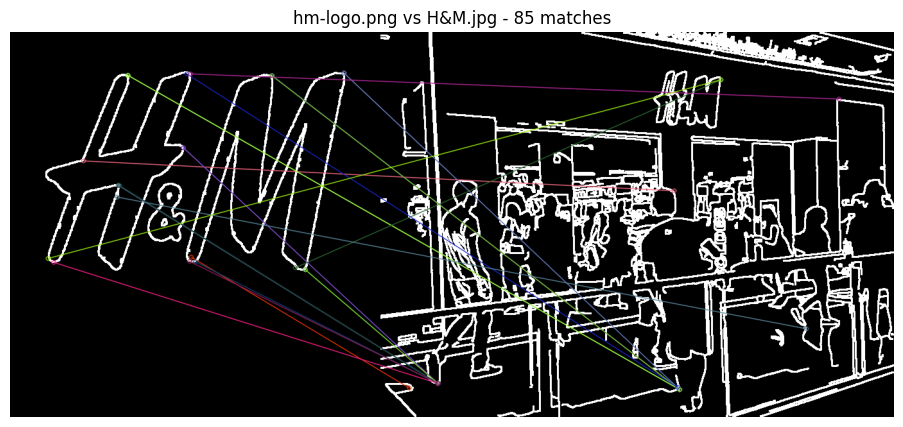


🚨 MARQUE DÉTECTÉE: H&M (Hennes & Mauritz)

📌 Contexte:
   Malgré ses initiatives 'Conscious', H&M reste un acteur majeur de la fast fashion avec un impact environnemental considérable.

❌ Raisons de boycotter:
   1. Pratiques de greenwashing (communication trompeuse sur l'écologie)
   2. Salaires insuffisants pour les ouvriers du textile
   3. Tonnes de vêtements invendus brûlés chaque année
   4. Conditions de travail dangereuses dans les usines partenaires

✅ Alternatives recommandées:
   Achats responsables, réparation de vêtements, marques éthiques

⚠️  Pas de descripteurs pour : Shein-logo.png ou SHEIN.jpeg

                        📊 RÉSUMÉ DE L'ANALYSE                         

🚨 3 marque(s) de fast fashion détectée(s):

   • Primark (15 correspondances)
   • Zara (27 correspondances)
   • H&M (85 correspondances)

💡 Ces marques sont associées à:
   - Exploitation des travailleurs
   - Impact environnemental élevé
   - Modèle de surconsommation

✅ Privilégiez les alternatives du

In [8]:
def analyser_dataset_notebook():
    """Analyse complète avec affichage dans le notebook."""
    print("\n" + "🔍 FASTFASHOFF - Analyse en cours...".center(70))
    print("="*70 + "\n")
    
    debut = time.time()
    marques_detectees = []
    
    for i in range(len(IMAGES)):
        logo_path = LOGO_DIR / LOGOS[i]
        img_path = IMAGE_DIR / IMAGES[i]

        # Chargement
        imgLogo = load_image(logo_path, grayscale=True)
        img = load_image(img_path, grayscale=True)

        if imgLogo is None or img is None:
            print(f"⚠️  Impossible de lire : {LOGOS[i]} ou {IMAGES[i]}")
            continue

        # Filtrage
        imgLogo_filtered = filter_image(imgLogo)
        img_filtered = filter_image(img)

        # Extraction ORB
        kp0, des0 = extraire_features_orb(imgLogo_filtered)
        kp1, des1 = extraire_features_orb(img_filtered)

        if des0 is None or des1 is None:
            print(f"⚠️  Pas de descripteurs pour : {LOGOS[i]} ou {IMAGES[i]}")
            continue

        # Matching
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        # Validation
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            detection = {
                "logo": LOGOS[i],
                "image": IMAGES[i],
                "matches": len(good_matches),
                "distance_min": matches[0].distance if matches else 0
            }
            marques_detectees.append(detection)
            
            print(f"✓ Logo détecté: {LOGOS[i]}")
            print(f"  → Bons matches: {len(good_matches)}")
            print(f"  → Distance minimale: {matches[0].distance:.1f}\n")
            
            # Affichage visuel
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(f"{LOGOS[i]} vs {IMAGES[i]} - {len(good_matches)} matches")
            plt.axis('off')
            plt.show()
            
            # Affichage info boycott
            afficher_info_boycott(LOGOS[i])
        else:
            print(f"✗ Pas de détection : {LOGOS[i]} vs {IMAGES[i]}")
            print(f"  → Matches: {len(good_matches)} (minimum: {MIN_MATCHES})\n")
    
    # Résumé
    temps_ecoule = time.time() - debut
    afficher_resume(marques_detectees)
    afficher_statistiques_detection(marques_detectees)
    print(f"\n⏱️  Temps d'exécution : {temps_ecoule:.2f}s\n")
    
    return marques_detectees

# Lancer l'analyse
resultats = analyser_dataset_notebook()


## 7. Analyse d'une image spécifique


🔍 Analyse de: ZARA.jpeg

✓ primark-logo.png détecté (36 matches)


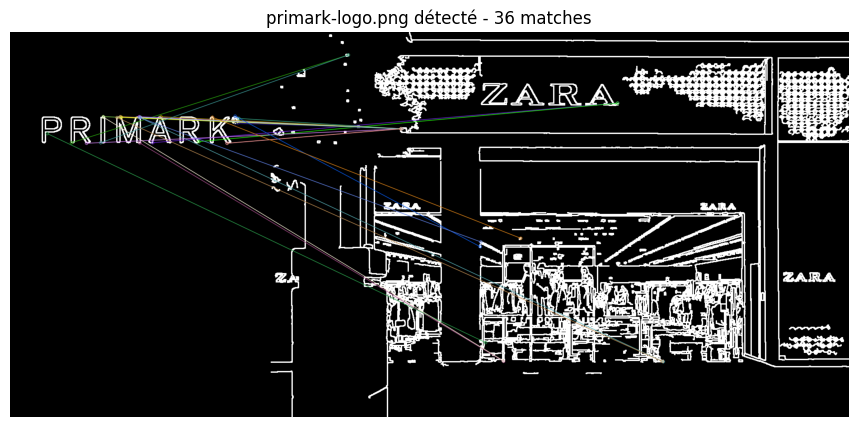

✓ zara_logo.png détecté (27 matches)


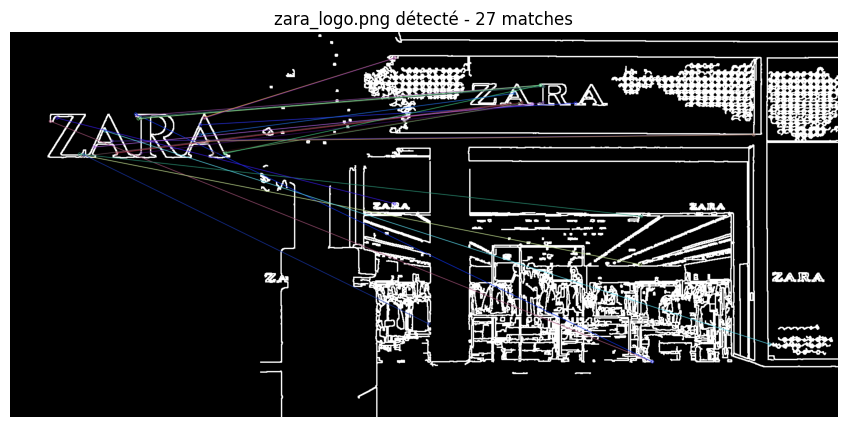

✓ hm-logo.png détecté (51 matches)


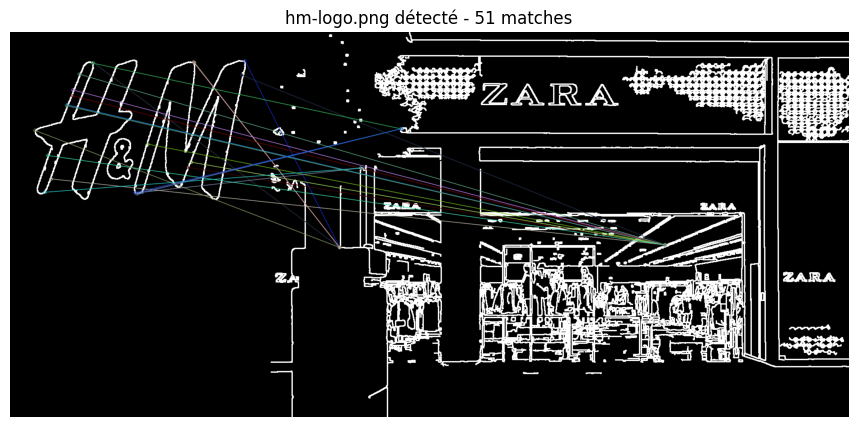

✓ uniqlo-logo.png détecté (71 matches)


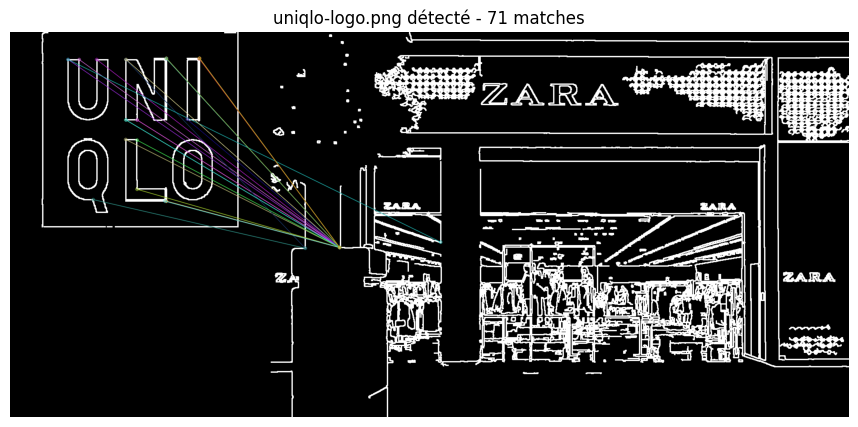


🚨 4 marque(s) trouvée(s):


🚨 MARQUE DÉTECTÉE: Primark

📌 Contexte:
   Impliqué dans l'effondrement du Rana Plaza (Bangladesh, 2013) qui a tué plus de 1100 personnes.

❌ Raisons de boycotter:
   1. Salaires très bas et horaires excessifs pour les ouvriers
   2. Absence de transparence sur la chaîne d'approvisionnement
   3. Modèle économique basé sur l'ultra fast-fashion
   4. Utilisation massive de matières polluantes (polyester)

✅ Alternatives recommandées:
   Friperies, location de vêtements, marques responsables


🚨 MARQUE DÉTECTÉE: Zara (groupe Inditex)

📌 Contexte:
   Leader mondial de la fast fashion. Inditex est régulièrement pointé du doigt pour ses pratiques sociales et environnementales.

❌ Raisons de boycotter:
   1. Rythme de production effréné (nouvelles collections toutes les 2 semaines)
   2. Exploitation des travailleurs dans les pays en développement
   3. Gaspillage textile massif (invendus détruits)
   4. Empreinte carbone élevée due à la logistique mondiale

✅ Al

[{'logo': 'primark-logo.png', 'matches': 36, 'distance_min': 17.0},
 {'logo': 'zara_logo.png', 'matches': 27, 'distance_min': 9.0},
 {'logo': 'hm-logo.png', 'matches': 51, 'distance_min': 22.0},
 {'logo': 'uniqlo-logo.png', 'matches': 71, 'distance_min': 11.0}]

In [9]:
def analyser_image_notebook(nom_image):
    """Analyse une image spécifique et cherche tous les logos."""
    img_path = IMAGE_DIR / nom_image
    img = load_image(img_path, grayscale=True)
    
    if img is None:
        print(f"❌ Impossible de lire l'image: {nom_image}")
        return
    
    print(f"\n🔍 Analyse de: {nom_image}\n")
    img_filtered = filter_image(img)
    
    marques_trouvees = []
    
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            continue
        
        imgLogo_filtered = filter_image(imgLogo)
        
        kp0, des0 = extraire_features_orb(imgLogo_filtered)
        kp1, des1 = extraire_features_orb(img_filtered)
        
        if des0 is None or des1 is None:
            continue
        
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            marques_trouvees.append({
                "logo": logo_name,
                "matches": len(good_matches),
                "distance_min": matches[0].distance
            })
            print(f"✓ {logo_name} détecté ({len(good_matches)} matches)")
            
            # Affichage visuel
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(f"{logo_name} détecté - {len(good_matches)} matches")
            plt.axis('off')
            plt.show()
    
    if marques_trouvees:
        print(f"\n🚨 {len(marques_trouvees)} marque(s) trouvée(s):\n")
        for detection in marques_trouvees:
            afficher_info_boycott(detection['logo'])
    else:
        print("\n✅ Aucune marque de fast fashion détectée!")
    
    return marques_trouvees

# Exemple : analyser l'image ZARA
analyser_image_notebook("ZARA.jpeg")

## 8. Interface utilisateur - Analyse d'une image au choix

In [ ]:
# Matching (avec ratio test de Lowe)
matches = matcher_logos(des_logo, des_img)
good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)

# Validation géométrique (NOUVEAU)
valide_geo, nb_inliers = valider_avec_homographie(kp_logo, kp_img, good_matches, 10)

# Affichage résultat pour cette paire
if len(good_matches) >= MIN_MATCHES and valide_geo:  # ← Ajout condition géométrique
    print(f"  ✓ {img_name:15} → {len(good_matches):3} matches ({nb_inliers} inliers, dist min: {matches[0].distance:.1f})")
    
    # Garder trace du meilleur match (basé sur les inliers, pas les matches)
    if nb_inliers > meilleur_score:  # ← Changé : on compare les inliers
        meilleur_score = nb_inliers
        meilleur_match = {
            'image': img_name,
            'matches': len(good_matches),
            'inliers': nb_inliers,
            'distance': matches[0].distance,
            'kp_logo': kp_logo,
            'kp_img': kp_img,
            'img_logo': imgLogo_filtered,
            'img': img_filtered,
            'all_matches': matches
        }
else:
    if valide_geo:
        raison = "insuffisant"
    else:
        raison = "géométrie invalide"
    print(f"  ✗ {img_name:15} → {len(good_matches):3} matches ({raison})")


                  RECHERCHE DE LOGOS DANS LES IMAGES                  

⚠️  Pas de descripteurs pour le logo : Bershka-logo.png


🔍 Recherche de primark-logo.png dans toutes les images:
----------------------------------------------------------------------
  ✓ BERSHKA.jpg     →  33 bons matches (dist min: 13.0)
  ✓ PRIMARK.jpg     →  15 bons matches (dist min: 21.0)
  ✓ ZARA.jpeg       →  36 bons matches (dist min: 17.0)
  ✓ H&M.jpg         →  37 bons matches (dist min: 17.0)
  ✓ SHEIN.jpeg      →  36 bons matches (dist min: 23.0)

🎯 MEILLEURE CORRESPONDANCE pour primark-logo.png:
   → H&M.jpg avec 37 matches



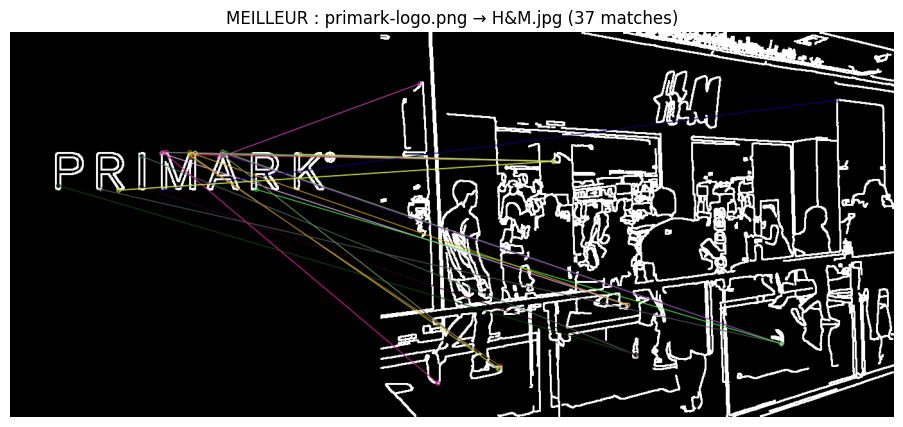


🔍 Recherche de zara_logo.png dans toutes les images:
----------------------------------------------------------------------
  ✓ BERSHKA.jpg     →  37 bons matches (dist min: 18.0)
  ✓ PRIMARK.jpg     →  26 bons matches (dist min: 28.0)
  ✓ ZARA.jpeg       →  27 bons matches (dist min: 9.0)
  ✓ H&M.jpg         →  35 bons matches (dist min: 16.0)
  ✓ SHEIN.jpeg      →  19 bons matches (dist min: 32.0)

🎯 MEILLEURE CORRESPONDANCE pour zara_logo.png:
   → BERSHKA.jpg avec 37 matches



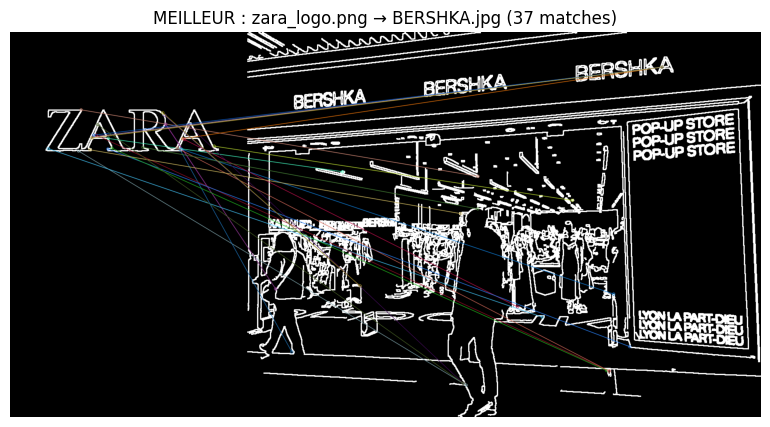


🔍 Recherche de hm-logo.png dans toutes les images:
----------------------------------------------------------------------
  ✓ BERSHKA.jpg     →  63 bons matches (dist min: 12.0)
  ✓ PRIMARK.jpg     →  18 bons matches (dist min: 31.0)
  ✓ ZARA.jpeg       →  51 bons matches (dist min: 22.0)
  ✓ H&M.jpg         →  85 bons matches (dist min: 15.0)
  ✓ SHEIN.jpeg      →  12 bons matches (dist min: 31.0)

🎯 MEILLEURE CORRESPONDANCE pour hm-logo.png:
   → H&M.jpg avec 85 matches



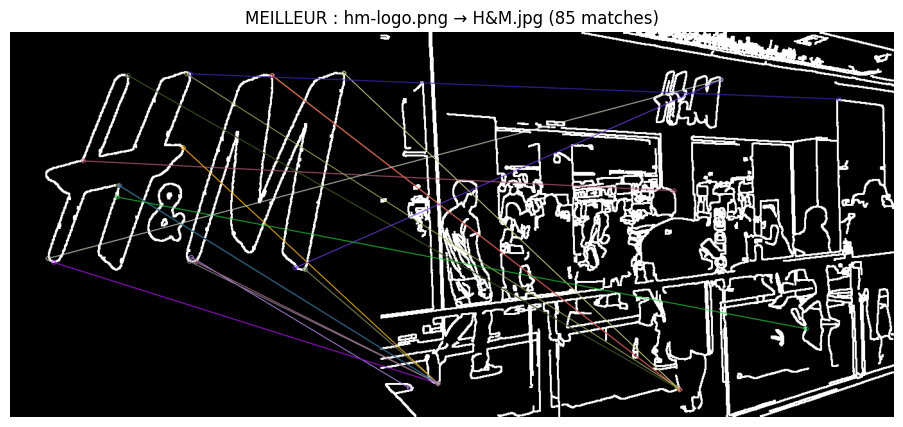

⚠️  Pas de descripteurs pour le logo : Shein-logo.png


🔍 Recherche de uniqlo-logo.png dans toutes les images:
----------------------------------------------------------------------
  ✓ BERSHKA.jpg     →  57 bons matches (dist min: 16.0)
  ✓ PRIMARK.jpg     →  16 bons matches (dist min: 31.0)
  ✓ ZARA.jpeg       →  71 bons matches (dist min: 11.0)
  ✓ H&M.jpg         →  90 bons matches (dist min: 10.0)
  ✓ SHEIN.jpeg      →  10 bons matches (dist min: 29.0)

🎯 MEILLEURE CORRESPONDANCE pour uniqlo-logo.png:
   → H&M.jpg avec 90 matches



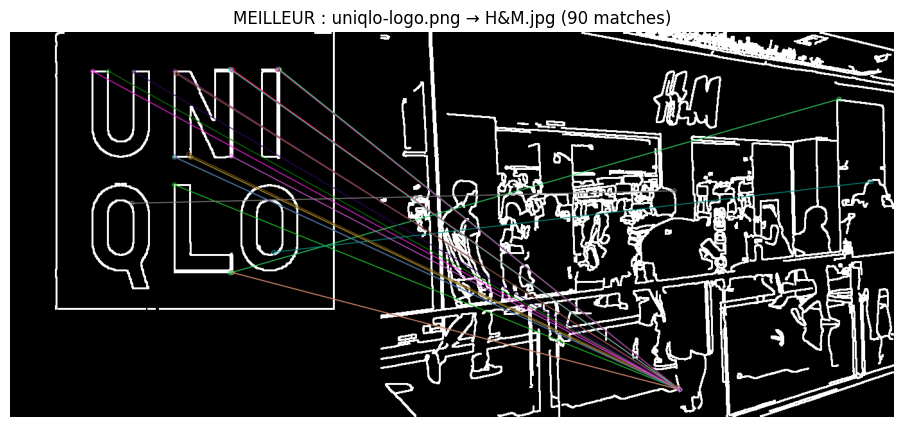


🔍 Recherche de Pull_Bear-logo.png dans toutes les images:
----------------------------------------------------------------------
  ✗ BERSHKA.jpg     →   7 matches (insuffisant)
  ✗ PRIMARK.jpg     →   1 matches (insuffisant)
  ✗ ZARA.jpeg       →   2 matches (insuffisant)
  ✗ H&M.jpg         →   0 matches (insuffisant)
  ✗ SHEIN.jpeg      →   3 matches (insuffisant)

❌ Aucune correspondance trouvée pour Pull_Bear-logo.png


                 RÉSUMÉ DES CORRESPONDANCES TROUVÉES                  

  primark-logo.png          → H&M.jpg         (37 matches)
  zara_logo.png             → BERSHKA.jpg     (37 matches)
  hm-logo.png               → H&M.jpg         (85 matches)
  uniqlo-logo.png           → H&M.jpg         (90 matches)




In [13]:
resultats = main_for_test()

In [ ]:
def main_for_user():
    """
    Demande à l'utilisateur le nom d'une image et affiche les logos détectés.
    """
    # Extensions acceptées
    ext = ['.png', '.jpg', '.jpeg']
    
    # Demande du nom de l'image
    nom_fichier = str(input("Entrez le nom de l'image (avec ou sans extension) : "))
    
    # Vérification de l'extension si elle est donnée
    if not nom_fichier.lower()[-3:] in ext and not nom_fichier.lower()[-4:] in ext:
        new_ext = str(input("Entrez l'extension du fichier (avec ou sans le point) : "))
        
        # Vérification que l'extension commence bien par un point
        if new_ext[0] != '.':
            new_ext = '.' + new_ext
        nom_fichier += new_ext
    
    # Vérifier que le fichier existe
    img_path = IMAGE_DIR / nom_fichier
    
    if not img_path.exists():
        print(f"\n❌ Erreur : le fichier {nom_fichier} n'existe pas dans {IMAGE_DIR}")
        print(f"\nImages disponibles :")
        for img in IMAGES:
            print(f"  - {img}")
        return
    
    # Analyser l'image
    print(f"\n🔍 Analyse de : {nom_fichier}\n")
    
    img = load_image(img_path, grayscale=True)
    if img is None:
        print(f"❌ Impossible de charger l'image")
        return
    
    img_filtered = filter_image(img)
    
    marques_trouvees = []
    
    # Tester tous les logos contre cette image
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            continue
        
        imgLogo_filtered = filter_image(imgLogo)
        
        kp0, des0 = extraire_features_orb(imgLogo_filtered)
        kp1, des1 = extraire_features_orb(img_filtered)
        
        if des0 is None or des1 is None:
            continue
        
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            marques_trouvees.append({
                'logo': logo_name,
                'matches': len(good_matches),
                'distance_min': matches[0].distance
            })
            print(f"✓ {logo_name} détecté ({len(good_matches)} bons matches)")
            
            # Affichage visuel
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(f"{logo_name} détecté - {len(good_matches)} matches")
            plt.axis('off')
            plt.show()
    
    # Afficher les infos de boycott
    if marques_trouvees:
        print(f"\n🚨 {len(marques_trouvees)} marque(s) de fast fashion trouvée(s) :\n")
        for detection in marques_trouvees:
            afficher_info_boycott(detection['logo'])
    else:
        print("\n✅ Aucune marque de fast fashion détectée !")
    
    return marques_trouvees


In [ ]:
# Lancer l'interface utilisateur
main_for_user()

## 9. Tests et expérimentations

In [ ]:
def comparer_seuils():
    #Compare différents seuils de détection
    seuils_distance = [30, 40, 50, 60]
    seuils_min_matches = [10, 15, 20, 25]
    
    print("\n" + "="*70)
    print("COMPARAISON DE SEUILS".center(70))
    print("="*70 + "\n")
    
    resultats_comparaison = []
    
    for seuil_dist in seuils_distance:
        for min_match in seuils_min_matches:
            print(f"\nTest : SEUIL_DISTANCE={seuil_dist}, MIN_MATCHES={min_match}")
            print("-" * 50)
            
            detections = 0
            total_matches = 0
            
            for i in range(len(IMAGES)):
                logo_path = LOGO_DIR / LOGOS[i]
                img_path = IMAGE_DIR / IMAGES[i]
                
                imgLogo = load_image(logo_path, grayscale=True)
                img = load_image(img_path, grayscale=True)
                
                if imgLogo is None or img is None:
                    continue
                
                imgLogo_filtered = filter_image(imgLogo)
                img_filtered = filter_image(img)
                
                kp0, des0 = extraire_features_orb(imgLogo_filtered)
                kp1, des1 = extraire_features_orb(img_filtered)
                
                if des0 is None or des1 is None:
                    continue
                
                matches = matcher_logos(des0, des1)
                good_matches = filtrer_bons_matches(matches, seuil_dist)
                
                if valider_detection(matches, min_match, seuil_dist):
                    detections += 1
                    total_matches += len(good_matches)
            
            print(f"Détections : {detections}/{len(IMAGES)}")
            print(f"Total bons matches : {total_matches}")
            
            resultats_comparaison.append({
                "seuil_distance": seuil_dist,
                "min_matches": min_match,
                "detections": detections,
                "total_matches": total_matches
            })
    
    # Affichage tableau récapitulatif
    print("\n" + "="*70)
    print("TABLEAU RÉCAPITULATIF".center(70))
    print("="*70)
    print(f"{'Seuil Dist':<15} {'Min Matches':<15} {'Détections':<15} {'Total Matches':<15}")
    print("-" * 70)
    
    for res in resultats_comparaison:
        print(f"{res['seuil_distance']:<15} {res['min_matches']:<15} "
              f"{res['detections']:<15} {res['total_matches']:<15}")
    
    return resultats_comparaison

# Lancer la comparaison
resultats_seuils = comparer_seuils()


## 10. Informations sur les marques

In [ ]:
def afficher_toutes_marques():
    #Affiche les informations de toutes les marques
    print("\n" + "="*70)
    print("BASE DE DONNÉES DES MARQUES".center(70))
    print("="*70 + "\n")
    
    for marque_key, info in MARQUES_INFO.items():
        print(f"\n  {info['nom_complet']}")
        print("-" * 70)
        print(f"\n {info['faits']}")
        print(f"\n Raisons principales :")
        for i, raison in enumerate(info['raisons'][:3], 1):  # Top 3
            print(f"   {i}. {raison}")
        print(f"\n Alternatives : {info['alternatives']}")
        print("\n" + "="*70)

afficher_toutes_marques()


## 11. Conclusion et perspectives


## 12. Ressources et références

### Documentation utilisée
- [OpenCV Documentation](https://docs.opencv.org/)
- [ORB Feature Detection](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html)
- [Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

### Sources sur la fast fashion
- Clean Clothes Campaign : https://cleanclothes.org/
- Fashion Revolution : https://www.fashionrevolution.org/
- Documentaire "The True Cost" (2015)
- Rapport Changing Markets Foundation

### Marques éthiques alternatives
- Good On You : https://goodonyou.eco/
- Clear Fashion : https://clearfashion.com/
- Slow Fashion Movement

In [ ]:
# Nettoyage final
print("\n✓ Notebook terminé")
print("Pour relancer l'analyse complète : analyser_dataset_notebook()")
print("Pour analyser une image : analyser_image_notebook('nom_fichier.jpg')")
print("Pour générer un rapport : generer_rapport_markdown(resultats)")
